In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data=pd.read_csv('drive/MyDrive/immo_data_clean2.csv',lineterminator='\n')
handy_data=data.copy()

In [4]:
def get_rid_outl(df, list_num_var, percentile):
    """
    INPUT: 
    df: Dataframe
    list_num_var: List of the variables (columns) with outliers that need to be deleted
    percentile: float between 0 and 100: Percentage of the data that will be kept 
    
    OUTPUT:
    DataFrame with the defined amount of data. This means a DataFrame without outliers
    """
    
    perc_dict = {}
    for col in list_num_var: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_num_var:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [5]:
handy_data.loc[handy_data.yearConstructed == "NO_INFORMATION", "yearConstructed"] = '0'
handy_data['yearConstructed']=handy_data['yearConstructed'].astype(int)
handy_data.loc[handy_data.yearConstructed == 0, "yearConstructed"] = None

In [6]:
handy_data['yearConstructed'] = handy_data['yearConstructed'].fillna(handy_data['yearConstructed'].median())

In [7]:
handy_data.drop(columns=['totalRent',
                 'serviceCharge',
                 'heatingCosts'], inplace=True)

# rename the response variable to rent
handy_data.rename(columns={'rent_incl_hc': 'rent'}, inplace=True)

# remove all rows where living space is 0
handy_data = handy_data[handy_data['livingSpace'] != 0]

# create a new variable for the rent/livingSpace (rent/m2)
handy_data['rent_m2'] = handy_data['rent'] / handy_data['livingSpace']

# get rid of outliers
handy_data = get_rid_outl(handy_data, ['rent_m2'], 99.8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [8]:
handy_data.typeOfFlat.replace(np.nan, 'NO_INFORMATION', inplace=True)
handy_data.interiorQuality.replace(np.nan, 'NO_INFORMATION', inplace=True)

In [9]:
handy_data_new=handy_data[[feat for feat in handy_data.columns.to_list() if feat not in ['Unnamed: 0']] ]

In [10]:
y = handy_data_new['rent']
X = handy_data_new[[i for i in handy_data_new.columns if i not in ['rent', 'rent_m2']]]
train, test = train_test_split(pd.concat([X,y],axis=1), test_size=0.2,random_state=42)
df_train,df_test=train.copy(),test.copy()
df_train['split']='train'
df_test['split']='test'
print('{:,} training samples'.format(len(df_train)))
print('{:,} test samples'.format(len(df_test)))

# Confirm the columns match between the two.
assert(set(df_train.columns) == set(df_test.columns))

# Combine the two into a single dataframe for processing. We'll split them back
# apart later, using the 'split' column we added.
df = pd.concat([df_train, df_test])

# Use empty string to represent any empty cells.
df.fillna(value='', inplace=True)

173,613 training samples
43,404 test samples


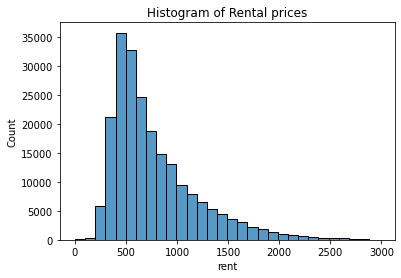

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the rental prices.
ax = sns.histplot(df['rent'], bins=30)

t = ax.set_title('Histogram of Rental prices')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217017 entries, 192241 to 55688
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   regionLevel1           217017 non-null  object 
 1   heatingType            217017 non-null  object 
 2   newlyConst             217017 non-null  bool   
 3   balcony                217017 non-null  bool   
 4   yearConstructed        217017 non-null  float64
 5   noParkSpaces           217017 non-null  float64
 6   kitchen                217017 non-null  bool   
 7   cellar                 217017 non-null  bool   
 8   livingSpace            217017 non-null  float64
 9   condition              217017 non-null  object 
 10  interiorQuality        217017 non-null  object 
 11  petsAllowed            217017 non-null  object 
 12  lift                   217017 non-null  bool   
 13  typeOfFlat             217017 non-null  object 
 14  postcode               217017 no

In [1]:
col_info = {}

# Specify our text features.
col_info['text_cols'] = [
   # categorical features
  'regionLevel1',
 'heatingType',
 'condition',
 'interiorQuality',
 'petsAllowed',
 'typeOfFlat',
 'floor',
 'numberOfFloors',
 'regionLevel2',
 'regionLevel3',
 'energyEfficiencyClass',
 'lastRefurbish',
    # Text Features.
  'description',
  'facilities'  
]

# Specify our numerical features.
col_info['num_cols'] = [ 
  'yearConstructed',
  'noParkSpaces',
   'livingSpace',
    'noRooms',
    'postcode'
]

# Specify our categorical features--all of these are binary. 
col_info['cat_cols'] = [
 'newlyConst',
 'balcony',
 'kitchen', 
 'cellar',
  'lift', 
  'garden']




In [3]:
len(col_info['text_cols'])

14

In [14]:
print('There are:')
print('  {:,}  numerical features'.format(len(col_info['num_cols'])))
print('  {:,}  categorical features'.format(len(col_info['cat_cols'])))
print('  {:,}  text features'.format(len(col_info['text_cols'])))


There are:
  5  numerical features
  6  categorical features
  14  text features


In [15]:
# Select just the columns we're using.
data_df = df[col_info['text_cols'] +  
             col_info['num_cols'] +
             col_info['cat_cols'] + 
             ['rent', 'split']] # 'rent' is our label.
              

data_df.head()

,regionLevel1,heatingType,condition,interiorQuality,petsAllowed,typeOfFlat,floor,numberOfFloors,regionLevel2,regionLevel3,...,noRooms,postcode,newlyConst,balcony,kitchen,cellar,lift,garden,rent,split
192241,Sachsen,central_heating,well_kept,normal,negotiable,apartment,1.0,2.0,Sächsische_Schweiz_Osterzgebirge_Kreis,Freital,...,2.0,1705,False,False,True,True,False,True,410.0,train
131248,Sachsen,central_heating,refurbished,normal,,roof_storey,3.0,NO_INFORMATION,Bautzen_Kreis,Bernsdorf,...,4.0,2994,False,False,False,True,False,False,762.0,train
64389,Sachsen,,,NO_INFORMATION,,NO_INFORMATION,1.0,NO_INFORMATION,Bautzen_Kreis,Hochkirch,...,2.0,2627,False,False,False,False,False,False,318.5,train
155488,Baden_Württemberg,self_contained_central_heating,first_time_use_after_refurbishment,normal,no,apartment,1.0,3.0,Stuttgart,Büsnau,...,3.0,70569,False,True,False,True,False,False,930.0,train
87135,Hessen,central_heating,well_kept,normal,negotiable,apartment,1.0,2.0,Gießen_Kreis,Langgöns,...,3.0,35428,False,True,False,True,False,False,850.0,train


## S2. Prepare Numerical & Categorical Features


A couple pre-processing steps need to be performed:

1. Our binary features are currently represented as 't' or 'f', but we'll need to change this to 1 and 0.
2. We'll normalize each numerical feature.



### 2.1. Binary Features

Replace the 't' and 'f' values with 1 and 0. 
 

In [16]:
# Disable those pesky "SettingWithCopyWarning" messages.
pd.options.mode.chained_assignment = None  # default='warn'

print('Converting categorical features to integers...')

# For each of the categorical features...
for col_name in col_info['cat_cols']:

    # Get the number of unique values for this category.
    num_unique = len(data_df[col_name].unique())
    
    # If there are more than two, warn about it.
    if num_unique > 2:
        print('Note! Column "{:}" has {:,} possible values.'.format(col_name, num_unique))

    # First, change the type of the specified columns to "category". This will 
    # assign a "code" to each unique category value.
    data_df[col_name] = data_df[col_name].astype('category')

    # Second, replace the strings with their code values.
    data_df[col_name] = data_df[col_name].cat.codes.astype('float')

print('DONE.')

Converting categorical features to integers...
DONE.


In [17]:
# Display the category columns after the transformation.
data_df[col_info['cat_cols']].head()

,newlyConst,balcony,kitchen,cellar,lift,garden
192241,0.0,0.0,1.0,1.0,0.0,1.0
131248,0.0,0.0,0.0,1.0,0.0,0.0
64389,0.0,0.0,0.0,0.0,0.0,0.0
155488,0.0,1.0,0.0,1.0,0.0,0.0
87135,0.0,1.0,0.0,1.0,0.0,0.0


### 2.2. Normalize Feature Distributions

Normalization can help the MLP out if we shift and re-scale the ranges of each feature so they all have similar distributions, so we'll do normalization here.

First, let's display the numerical features pre-transformation.

In [18]:
# Display the numerical features prior to our transformation.
data_df[col_info['num_cols']].head()

,yearConstructed,noParkSpaces,livingSpace,noRooms,postcode
192241,1900.0,0.0,50.00,2.0,1705
131248,1912.0,1.0,98.87,4.0,2994
64389,1968.0,0.0,49.00,2.0,2627
155488,1969.0,0.0,68.00,3.0,70569
87135,1992.0,1.0,95.00,3.0,35428


In [19]:
from sklearn.preprocessing import QuantileTransformer

# Disable those pesky "SettingWithCopyWarning" messages.
pd.options.mode.chained_assignment = None  # default='warn'

# For each of the numerical featuress...
for col_name in col_info['num_cols']:
    
    # Select the column.
    num_df = data_df[col_name]

    # Replace any empty cells with 0.
    num_df.replace('', 0, inplace=True)

    # The column values are a 1D array, but the transformation function requires
    # it to be a 2D array. Reshape it into a column vector. 
    col_values = num_df.values.reshape(-1, 1)

    # Create a quantile transformer that transforms the feature
    # to have a normal distribution.
    numerical_transformer = QuantileTransformer(output_distribution='normal')
    
    # Apply the transformation.
    col_values_norm = numerical_transformer.fit_transform(col_values)

    # Replace the values with the normalized ones.
    data_df[col_name] = col_values_norm


In [20]:
# Display the numerical features after transformation.
data_df[col_info['num_cols']].head()

,yearConstructed,noParkSpaces,livingSpace,noRooms,postcode
192241,-1.649237,-5.199338,-0.844485,-0.552537,-1.773922
131248,-1.171890,0.931971,1.061725,1.453280,-1.537691
64389,-0.384375,-5.199338,-0.905189,-0.552537,-1.634517
155488,-0.360172,-5.199338,0.060256,0.447305,1.088776
87135,0.686350,0.931971,0.971436,0.447305,-0.023496


### 3.1. Combine Text

Loop through the dataset and concatenate all of the text features together.


In [21]:
text_combined = []

print('Combining all text features...')

# For each sample...
for (i, row) in data_df.iterrows():

    combined = ''

    # For each of the text columns...
    for text_col in col_info['text_cols']:
        
        # Append the feature to the combined text, with a 'SEP' token in between.
        combined += (str(row[text_col]) + ' [SEP] ')

    text_combined.append(combined)

# Sanity check that the resulting list is the same length as the data frame.
assert(len(text_combined) == len(data_df))

print('  DONE.')

Combining all text features...
  DONE.


In [22]:
# Remove the original text feature columns.
data_df = data_df.drop(columns = col_info['text_cols'])

# Add the combined text as the first column.
data_df.insert(0, 'text', text_combined)

data_df.head()

,text,yearConstructed,noParkSpaces,livingSpace,noRooms,postcode,newlyConst,balcony,kitchen,cellar,lift,garden,rent,split
192241,Sachsen [SEP] central_heating [SEP] well_kept ...,-1.649237,-5.199338,-0.844485,-0.552537,-1.773922,0.0,0.0,1.0,1.0,0.0,1.0,410.0,train
131248,Sachsen [SEP] central_heating [SEP] refurbishe...,-1.171890,0.931971,1.061725,1.453280,-1.537691,0.0,0.0,0.0,1.0,0.0,0.0,762.0,train
64389,Sachsen [SEP] [SEP] [SEP] NO_INFORMATION [SE...,-0.384375,-5.199338,-0.905189,-0.552537,-1.634517,0.0,0.0,0.0,0.0,0.0,0.0,318.5,train
155488,Baden_Württemberg [SEP] self_contained_central...,-0.360172,-5.199338,0.060256,0.447305,1.088776,0.0,1.0,0.0,1.0,0.0,0.0,930.0,train
87135,Hessen [SEP] central_heating [SEP] well_kept [...,0.686350,0.931971,0.971436,0.447305,-0.023496,0.0,1.0,0.0,1.0,0.0,0.0,850.0,train


In [23]:
!pip install transformers

In [24]:
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Another key parameter is our "maximum sequence length", which we will truncate or pad all of our samples to. Setting this to a higher value requires more memory and slows down training, so we want to see how short we can get away with.

We'll run a pass over the dataset to find the longest sequence and use this to inform our choice. 

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


Tokenizing all 217,017 samples to measure lengths...
       0
   2,000
   4,000
   6,000
   8,000
  10,000
  12,000
  14,000
  16,000
  18,000
  20,000
  22,000
  24,000
  26,000
  28,000
  30,000
  32,000
  34,000
  36,000
  38,000
  40,000
  42,000
  44,000
  46,000
  48,000
  50,000
  52,000
  54,000
  56,000
  58,000
  60,000
  62,000
  64,000
  66,000
  68,000
  70,000
  72,000
  74,000
  76,000
  78,000
  80,000
  82,000
  84,000
  86,000
  88,000
  90,000
  92,000
  94,000
  96,000
  98,000
  100,000
  102,000
  104,000
  106,000
  108,000
  110,000
  112,000
  114,000
  116,000
  118,000
  120,000
  122,000
  124,000
  126,000
  128,000
  130,000
  132,000
  134,000
  136,000
  138,000
  140,000
  142,000
  144,000
  146,000
  148,000
  150,000
  152,000
  154,000
  156,000
  158,000
  160,000
  162,000
  164,000
  166,000
  168,000
  170,000
  172,000
  174,000
  176,000
  178,000
  180,000
  182,000
  184,000
  186,000
  188,000
  190,000
  192,000
  194,000
  196,000
  198,0

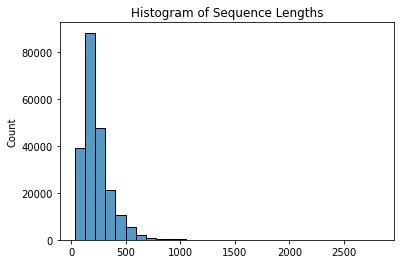

In [25]:
import numpy as np

analyze_lengths = True

if analyze_lengths:
    
    seq_lens = []

    print('Tokenizing all {:,} samples to measure lengths...'.format(len(text_combined)))

    # For each of the samples...
    for (i, text) in enumerate(text_combined):

        # Print progress every 2k samples.
        if ((i % 2000) == 0):
            print('  {:>6,}'.format(i))

        # Tokenize the text.
        input_ids = tokenizer.encode(text)

        # Store the length.
        seq_lens.append(len(input_ids))

    print('DONE.\n')

    print('Longest sequence: ', max(seq_lens))
    print('Median:', round(np.median(seq_lens)))

    # Plot a histogram of the rental prices.
    ax = sns.histplot(seq_lens, bins=30)

    t = ax.set_title('Histogram of Sequence Lengths')


I'm going to start with a max_len of 600, just to speed up training. We can try a longer length next.

In [26]:
# Specify the length to pad / truncate all sequences to.
max_len = 400

**Training Split**

In [27]:
# Re-split the dataset.
test_df = data_df.loc[data_df.split == 'test']
train_df = data_df.loc[data_df.split == 'train']

print('After filtering:')
print('  {:,} training samples'.format(len(train_df)))
print('  {:,} test samples'.format(len(test_df)))

After filtering:
  173,613 training samples
  43,404 test samples


Now we can do the real tokenization and encoding.


In [28]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

attention_masks = []

print('Encoding {:,} text samples...'.format(len(train_df)))

num_done = 0

# For each of the samples...
for (row_i, row) in train_df.iterrows():

    # Update every 2k samples.
    if ((num_done % 2000) == 0):
        print('  {:>6,}'.format(num_done))

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        row['text'],                  # Sentence to encode.
                        max_length = max_len,  # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    num_done += 1



Encoding 173,613 text samples...
       0
   2,000
   4,000
   6,000
   8,000
  10,000
  12,000
  14,000
  16,000
  18,000
  20,000
  22,000
  24,000
  26,000
  28,000
  30,000
  32,000
  34,000
  36,000
  38,000
  40,000
  42,000
  44,000
  46,000
  48,000
  50,000
  52,000
  54,000
  56,000
  58,000
  60,000
  62,000
  64,000
  66,000
  68,000
  70,000
  72,000
  74,000
  76,000
  78,000
  80,000
  82,000
  84,000
  86,000
  88,000
  90,000
  92,000
  94,000
  96,000
  98,000
  100,000
  102,000
  104,000
  106,000
  108,000
  110,000
  112,000
  114,000
  116,000
  118,000
  120,000
  122,000
  124,000
  126,000
  128,000
  130,000
  132,000
  134,000
  136,000
  138,000
  140,000
  142,000
  144,000
  146,000
  148,000
  150,000
  152,000
  154,000
  156,000
  158,000
  160,000
  162,000
  164,000
  166,000
  168,000
  170,000
  172,000


In [29]:
import torch

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('DONE.')

DONE.


Create PyTorch tensors for the labels and categorical features.

In [30]:
import torch

# Tensor for labels.
labels = torch.tensor(train_df['rent'].values)

# Tensor for categorical features.
categorical_feats = torch.tensor(train_df[col_info['cat_cols']].values, dtype=torch.float32)

# Tensor for numerical features.
numerical_feats = torch.tensor(train_df[col_info['num_cols']].values.astype('float'), dtype=torch.float32)

In [31]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, categorical_feats, numerical_feats, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

156,251 training samples
17,362 validation samples


In order to implement our model, we need to define our own BERT class based on `BertForSequenceClassification`.

I named our custom class `BertConcatFeatures`. 

One component of our custom model is the multi-layer neural network (a.k.a. Multi-Layer Perceptron or "MLP") that we'll use on the output to generate our actual price prediction.  We'll define our `MLP` class first, then use it as a component within `BertConcatFeatures`.

> *Why an MLP?* 
> Normally, with BERT we just use a simple linear classifier on the output. That's because BERT is a massive and powerful model, and is able to encode everything needed for a simple classification into the `[CLS]` embedding.
> Here, though, we have some additional features outside of BERT, so we'll want a more sophisticated model on the output that's able to combine the different sources of information intelligently.

Below is the definition of our MLP model, which we'll use on the output to generate our final prediction. 


In [32]:
import math
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss


class MLP(nn.Module):
    """mlp can specify number of hidden layers and hidden layer channels"""

    def __init__(self, input_dim, output_dim, num_hidden_lyr=2,
                 dropout_prob=0.5, return_layer_outs=False,
                 hidden_channels=None, bn=False):
        super().__init__()
        self.out_dim = output_dim
        self.dropout = nn.Dropout(dropout_prob)
        self.return_layer_outs = return_layer_outs
        if not hidden_channels:
            hidden_channels = [input_dim for _ in range(num_hidden_lyr)]
        elif len(hidden_channels) != num_hidden_lyr:
            raise ValueError(
                "number of hidden layers should be the same as the lengh of hidden_channels")
        self.layer_channels = [input_dim] + hidden_channels + [output_dim]
        self.act_name = 'relu'
        self.activation = nn.ReLU()
        self.layers = nn.ModuleList(list(
            map(self.weight_init, [nn.Linear(self.layer_channels[i], self.layer_channels[i + 1])
                                   for i in range(len(self.layer_channels) - 2)])))
        final_layer = nn.Linear(self.layer_channels[-2], self.layer_channels[-1])
        self.weight_init(final_layer,   activation='linear')
        self.layers.append(final_layer)

        self.bn = bn
        if self.bn:
            self.bn = nn.ModuleList([torch.nn.BatchNorm1d(dim) for dim in self.layer_channels[1:-1]])

    def weight_init(self, m, activation=None):
        if activation is None:
            activation = self.act_name
        torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain(activation))
        return m

    def forward(self, x):
        """
        :param x: the input features
        :return: tuple containing output of MLP,
                and list of inputs and outputs at every layer
        """
        layer_inputs = [x]
        for i, layer in enumerate(self.layers):
            input = layer_inputs[-1]
            if layer == self.layers[-1]:
                layer_inputs.append(layer(input))
            else:
                if self.bn:
                    output = self.activation(self.bn[i](layer(input)))
                else:
                    output = self.activation(layer(input))
                layer_inputs.append(self.dropout(output))

        # model.store_layer_output(self, layer_inputs[-1])
        if self.return_layer_outs:
            return layer_inputs[-1], layer_inputs
        else:
            return layer_inputs[-1]


In [33]:
from torch import nn

from transformers import BertForSequenceClassification


class BertConcatFeatures(BertForSequenceClassification):
    """
    A model for classification or regression which combines text, categorical,
    and numerical features. The text features are processed with BERT. All
    features are concatenated into a single vector, which is fed into an MLP
    for final classification / regression.

    This class expects a transformers.BertConfig object, and the config object
    needs to have three additional properties manually added to it:
      `text_feat_dim` - The length of the BERT vector.
      `cat_feat_dim` - The number of categorical features.
      `numerical_feat_dim` - The number of numerical features.
    """

    def __init__(self, config):
        
        # ====================
        #     BERT Setup
        # ====================

        # Call the constructor for the huggingface `BertForSequenceClassification` 
        # class, which will do all of the BERT-related setup. The resulting BERT
        # model is stored in `self.bert`. 
        super().__init__(config)
        
        # ==================================
        #     Feature Combination Setup
        # ==================================

        # Store the number of labels, which tells us whether this is a 
        # classification or regression task.
        self.num_labels = config.num_labels

        # Calculate the combined vector length. 
        combined_feat_dim = config.text_feat_dim + \
                            config.cat_feat_dim + \
                            config.numerical_feat_dim

        # Create a batch normalizer for the numerical features.
        self.num_bn = nn.BatchNorm1d(config.numerical_feat_dim)

        # ====================
        #     MLP Setup
        # ====================

        # To setup the MLP, we need to specify the number of layers and the
        # number of neurons in each layer. The MultiModal-Toolkit has a formula
        # for picking these dimensions. Each layer of the MLP has 1/4th the 
        # number of neurons as the previous one. 
        
        # Dimensions of each MLP layer.
        dims = []

        # Starting with the combined feature vector length...
        dim = combined_feat_dim

        # Keep dividing by 4 until we drop below the number of outputs the MLP
        # needs to have. 
        while True:
            
            # Divide by 4 and truncate to an integer.
            dim = dim // 4
            
            # If the resulting layer size would be smaller than the number of 
            # outputs, then we're done.
            if dim <= self.num_labels:
                break
            
            # Otherwise, store this as the next layer size.
            dims.append(int(dim))

        # Print out the resulting MLP.                
        print('MLP layer sizes:')
        print('  Input:', combined_feat_dim)
        print('  Hidden:', dims)
        print('  Output:', self.num_labels)
        print('')

        # Construct the MLP, specifying the number of inputs, outputs, and the
        # layer sizes.
        self.mlp = MLP(combined_feat_dim,
                        self.num_labels,
                        num_hidden_lyr=len(dims),
                        dropout_prob=0.1,
                        hidden_channels=dims,
                        bn=True)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        class_weights=None,
        output_attentions=None,
        output_hidden_states=None,
        cat_feats=None,
        numerical_feats=None
    ):
        r"""
        Perform a forward pass of our model.
        
        This has the same inputs as `forward` in `BertForSequenceClassification`,
        but with two extra parameters:
          `cat_feats` - Tensor of categorical features.
          `numerical_feats` - Tensor of numerical features.  
        """
        
        # ====================
        #        BERT
        # ====================
       
        # Run the text through the BERT model. Invoking `self.bert` returns 
        # outputs from the encoding layers, and not from the final classifier.
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )
        
        # outputs[0] - All of the output embeddings from BERT
        # outputs[1] - The [CLS] token embedding, with some additional "pooling"
        #              done.
        cls = outputs[1]
        
        # Apply dropout to the CLS embedding.
        cls = self.dropout(cls)

        # ==========================
        #    Concatenate Features
        # ==========================        

        # Apply batch normalization to the numerical features.        
        numerical_feats = self.num_bn(numerical_feats)
    
        # Object sizes:
        #             cls   [batch size  x   768]
        # numerical_feats   [batch size  x   # numerical features]
        #       cat_feats   [batch size  x   # categorical features]
    
        # Simply concatenate everything into one vector.
        # For example, if we have 6 categ. and 5 numer. features, then the
        # result has 768 + 6 + 5 = 779 features.
        combined_feats = torch.cat((cls, cat_feats, numerical_feats),
                                    dim=1)
        
        # ====================================
        #    Output Classifier / Regression
        # ====================================        

        # Run the the samples through the MLP.
        logits = self.mlp(combined_feats)

        # TODO - Not sure what's going on with the outputs...

        if type(logits) is tuple:
            logits, classifier_layer_outputs = logits[0], logits[1]

        else:  # simple classifier
            classifier_layer_outputs = [combined_feats, logits]
        
        # =================
        #       Loss
        # =================

        # Calculate loss, but only if labels were provided.
        # (Labels aren't provided at test time).
        if labels is not None:

            # Regression
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()

                labels = labels.float()

                loss = loss_fct(logits.view(-1), labels.view(-1))
            
            # Classification
            else:
                loss_fct = CrossEntropyLoss(weight=class_weights)
                
                labels = labels.long()
                
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        # If no labels are provided, set the loss to 'None'.
        else:
            loss = None
        
        # Put the results into a Dictionary to return.
        results = {'loss': loss, 
                   'logits': logits,
                   'classifier_layer_outputs': classifier_layer_outputs}

        return results




In this section, we'll use our custom BERT class and load Google's pre-trained version of BERT.

The first step is to connect the GPU to PyTorch.

In [34]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Print out what GPU we've got.
    print('There are %d GPU(s) available:\n' % torch.cuda.device_count())
    print('    ', torch.cuda.get_device_name(0))

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda") 

# If not, you could use the CPU, but this isn't recommended!
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available:

     Tesla T4


Next we'll initialize our custom class. This involves loading the pre-trained weights of the BERT model as well as defining our output MLP and initializing its weights. 

In order to set up the MLP, we'll need to know the total feature dimensions, so we'll specify these using an instance of the BertConfig class.

In the output of this cell, note that it prints the size of each of the hidden layers in the MLP.

In [35]:
from transformers import BertConfig

# We'll need to a use a "BertConfig" object from the transformers library to
# specify our parameters. 
# model = AutoModelForMaskedLM.from_pretrained("bert-base-german-cased")

# First, specify the ordinary BERT parameters by taking them from the 
# 'bert-base-uncased' model. 
# Also set the number of labels.
config = BertConfig.from_pretrained(
        'bert-base-german-cased',
        num_labels=1, # The number of output labels--1 for regression.
    )

# To set up the MLP, we need to know the combined vector length that will be
# sent into it. 

# Pass in the number of numerical and categorical features.
config.numerical_feat_dim = numerical_feats.size()[1]
config.cat_feat_dim = categorical_feats.size()[1]

# Pass in the size of the text embedding.
# The text feature dimension is the "hidden_size" parameter which 
# comes from BertConfig. The length is 768 in BERT-base (and most other BERT
# models).
config.text_feat_dim = config.hidden_size # 768

# Now we're ready to do the actual set up of our model! Note that we're passing
# in the config object here.
model = BertConcatFeatures.from_pretrained(
    "bert-base-german-cased",
    config = config
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

MLP layer sizes:
  Input: 779
  Hidden: [194, 48, 12, 3]
  Output: 1



Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertConcatFeatures: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertConcatFeatures from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertConcatFeatures from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertConcatFeatures were not initialized from the model checkpoint at bert-base-german-cased and are newly i

In [36]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 16

# This is the learning rate specified in Ken's configuration
learning_rate = 3e-3

# Number of training epochs. 
epochs = 2

# Print out the max_len for reference. To change this, you'd need to set it
# back in section 3 prior to the tokenization and encoding of the text.
print('Using maximum sequence length:', max_len)

Using maximum sequence length: 400


In [37]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [38]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [40]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [41]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        b_input_ids = batch[0].to(device)
        b_categ_feats = batch[1].to(device)
        b_numer_feats = batch[2].to(device) 
        b_input_mask = batch[3].to(device)
        b_labels = batch[4].to(device)

        # Clear prior gradients. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. 
        # This will return the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       cat_feats = b_categ_feats,
                       numerical_feats = b_numer_feats)

        loss = result['loss']
        logits = result['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    # Include the batch size so that we are looking at the average per-sample
    # loss.
    avg_train_loss = total_train_loss / (len(train_dataloader) * batch_size)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_categ_feats = batch[1].to(device) # TODO - Comment...
        b_numer_feats = batch[2].to(device) 
        b_input_mask = batch[3].to(device)
        b_labels = batch[4].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           cat_feats = b_categ_feats,
                           numerical_feats = b_numer_feats)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result['loss']
        logits = result['logits']
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        prices = b_labels.to('cpu').numpy()        

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / (len(validation_dataloader) * batch_size)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch   100  of  9,766.    Elapsed: 0:01:49.
  Batch   200  of  9,766.    Elapsed: 0:03:48.
  Batch   300  of  9,766.    Elapsed: 0:05:47.
  Batch   400  of  9,766.    Elapsed: 0:07:45.
  Batch   500  of  9,766.    Elapsed: 0:09:44.
  Batch   600  of  9,766.    Elapsed: 0:11:42.
  Batch   700  of  9,766.    Elapsed: 0:13:41.
  Batch   800  of  9,766.    Elapsed: 0:15:39.
  Batch   900  of  9,766.    Elapsed: 0:17:37.
  Batch 1,000  of  9,766.    Elapsed: 0:19:36.
  Batch 1,100  of  9,766.    Elapsed: 0:21:34.
  Batch 1,200  of  9,766.    Elapsed: 0:23:32.
  Batch 1,300  of  9,766.    Elapsed: 0:25:30.
  Batch 1,400  of  9,766.    Elapsed: 0:27:29.
  Batch 1,500  of  9,766.    Elapsed: 0:29:27.
  Batch 1,600  of  9,766.    Elapsed: 0:31:26.
  Batch 1,700  of  9,766.    Elapsed: 0:33:24.
  Batch 1,800  of  9,766.    Elapsed: 0:35:23.
  Batch 1,900  of  9,766.    Elapsed: 0:37:21.
  Batch 2,000  of  9,766.    Elapsed: 0:39:20.
  Batch 2,100  of

## Training Results

Let's view the summary of the training process.

In [42]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,19462.26,4492.15,3:12:24,0:07:23
2,7103.88,4351.63,3:11:51,0:07:23


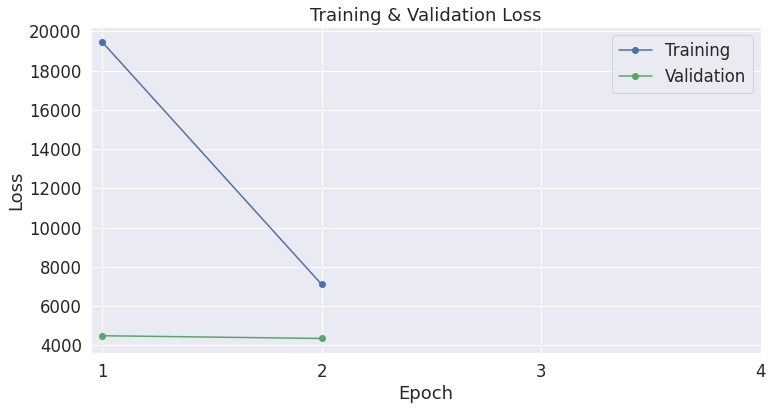

In [43]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Test

## Prepare Test Samples

The pre-processing of the categorical and numerical features was done on the full dataset, and then we split it back into training and test sets lately. 

The one step we still need to do here is to tokenize and encode the text features for BERT. 

Now we're ready to apply our fine-tuned model to the test set and see how we score.

In [44]:
import torch

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

attention_masks = []

print('Encoding {:,} text samples...'.format(len(test_df)))

num_done = 0

# For each of the samples...
for (row_i, row) in test_df.iterrows():

    # Update every 2k samples.
    if ((num_done % 2000) == 0):
        print('  {:>6,}'.format(num_done))

    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        row['text'],                  # Sentence to encode.
                        max_length = max_len,  # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

    num_done += 1

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

print('DONE.')

Encoding 43,404 text samples...
       0
   2,000
   4,000
   6,000
   8,000
  10,000
  12,000
  14,000
  16,000
  18,000
  20,000
  22,000
  24,000
  26,000
  28,000
  30,000
  32,000
  34,000
  36,000
  38,000
  40,000
  42,000
DONE.


In [45]:
import torch

# Tensor for labels.
labels = torch.tensor(test_df['rent'].values)

# Tensor for categorical features.
categorical_feats = torch.tensor(test_df[col_info['cat_cols']].values, dtype=torch.float32)

# Tensor for numerical features.
numerical_feats = torch.tensor(test_df[col_info['num_cols']].values.astype('float'), dtype=torch.float32)

In [46]:
from torch.utils.data import TensorDataset

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, categorical_feats, numerical_feats, attention_masks, labels)


## Evaluate Test Set

Now we're ready to score our trained model against the test set!

The below cell will generate all of the predictions.

In [47]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_categ_feats, b_numer_feats, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     cat_feats = b_categ_feats,
                     numerical_feats = b_numer_feats)


  logits = result['logits']

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 43,404 test sentences...
    DONE.


In [48]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

## Test Results

Now we can score the results!
The first is the Mean Absolute Error (MAE).


In [49]:
# Subtract the values from eachother, take the absolute value, then average them.
mae = abs(flat_predictions - flat_true_labels).mean()

print('MAE: %.2f' % mae)


MAE: 380.70


The second metric is the Root Mean Squared Error (RMSE). The RMSE more heavily punishes large errors because it squares the differences before averaging.

In [50]:
import math

# First, calculate the squared error for each individual prediction.
squared_diffs = (flat_predictions - flat_true_labels)**2

# Next, average these error values to get the MSE.
mse = squared_diffs.mean()

# Finally, take the square root to get the RMSE.
rmse = math.sqrt(mse)

print('RMSE: %.2f' % rmse)

RMSE: 516.35


In [51]:
tokenizer.save_pretrained("drive/MyDrive/local-pt-checkpoint")
model.save_pretrained("drive/MyDrive/local-pt-checkpoint")